In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from baseband_analysis.dev.Morphology_dev import *
%matplotlib inline
from IPython.display import clear_output
import gc

In [3]:
def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    
    ### Add cases when t_scrunch doesn't divide exactly ####
    data = npy_fil
    if (data.shape[1] % t_scrunch) == 0:
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    else:
        t_range = data.shape[1] - (data.shape[1] % t_scrunch) ### Make the number divisible by subtrating remainder
        print("Time range adjusted for scrunching", t_range)
        data = data[:,:t_range]
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def calc_xticks(wfall, t_res):
    
    ts = np.sum(wfall, axis=0)
    max_ts = np.argmax(ts)
    
    xticks = []
    num = 6
    step = int(len(ts)/num)
    
    
    for j in range(0,num):
        x_left = max_ts - step*j
        x_right = max_ts + step*(j+1)
        
        if x_left > 0:
            xticks.append(x_left)
        if x_right < len(ts):
            xticks.append(x_right)
    
    
    xticks = np.sort(np.unique(np.array(xticks)))
        
    xticks_lab = np.around(((xticks - max_ts) * t_res) / 1000, decimals=1).astype(float)
    
    # xticks_lab = np.around(((xticks - max_ts) * t_res), decimals=0).astype(int)
    
    
    return xticks, xticks_lab
    
    

def plot_event(wfall, freq_res, time_res, dm, i, save_fname=None, model_wfall=None, low_freq=400, high_freq=400):
    
    outer_grid = gridspec.GridSpec(1, 1, wspace=0, hspace=0.25)
    for j, outer in enumerate(outer_grid):
        outer = outer
    plt.figure(figsize=(6,6))
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer,
                                          width_ratios=[3, 1],
                                          height_ratios=[1, 3],
                                          hspace=0.0, wspace=0.0)

    data_im = plt.subplot(gs[2])
    data_ts = plt.subplot(gs[0], sharex=data_im)
    data_spec = plt.subplot(gs[3], sharey=data_im)
    
    vmin = np.nanpercentile(wfall, 1)
    vmax = np.nanpercentile(wfall, 99)
    


    wfall[np.isnan(wfall)] = np.nanmedian(wfall)
    print("Waterfall shape after scrunch", wfall.shape)
    
    if model_wfall is not None:
        model_ts = np.sum(model_wfall, axis=0)
    
    ts = np.sum(wfall, axis=0)
    spec = np.sum(wfall, axis=1)
    
    plot_time = np.arange(0,len(ts),1)
    plot_freq = np.linspace(400, 800, len(spec))

    
    #plot wfall
    data_im.imshow(wfall, aspect="auto", origin='lower',interpolation="none", 
                   vmin=vmin, vmax=vmax, cmap='viridis')

    #plot time series
    data_ts.plot(plot_time, ts, color="k", drawstyle="steps-post")

    # plot spectrum
    data_spec.plot(spec, np.arange(0, len(spec)), color="k", drawstyle="steps-post")
    
    if model_wfall is not None:
        data_ts.plot(np.arange(0,len(model_ts),1), model_ts,color="r")
    
    plt.setp(data_ts.get_xticklabels(), visible=False)
    data_ts.set_yticklabels([], visible=True)
    data_ts.set_yticks([])
    plt.setp(data_spec.get_yticklabels(), visible=False)
    data_spec.set_xticklabels([], visible=True)
    data_spec.set_xticks([])
    
    ## Tick Labels ###
    y_ticks = np.linspace(0,len(spec),5).astype(int)
    if y_ticks[-1] > (len(spec)-1):
        y_ticks[-1] = len(spec) - 1
    yticklabels = [400, 500, 600, 700, 800]#plot_freq[y_ticks].astype(int)
    x_ticks, xticklabels = calc_xticks(wfall, t_res)
    
    low_idx = (np.abs(plot_freq - low_freq)).argmin() ### Calculating the idx where frequency is closest ###
    high_idx = (np.abs(plot_freq - high_freq)).argmin() 
    
    data_im.axhline(low_idx, c='white', linestyle = '--')
    data_im.axhline(high_idx, c='white', linestyle = '--')

    
    data_im.set_yticks(y_ticks)
    data_im.set_yticklabels(yticklabels, fontsize=14)
    data_im.set_xticks(x_ticks)
    data_im.set_xticklabels(xticklabels, fontsize=14)
    data_im.set_ylabel("Frequency (MHz)", fontsize=14)
    data_im.set_xlabel("Time (ms)", fontsize=14)
    #data_im.set_xlabel("Time (us)", fontsize=14)
    
    xlim = data_ts.get_xlim()
    ylim = data_ts.get_ylim()
    ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
    xpos = (xlim[1] - xlim[0]) * 0.98 + 0
    data_ts.text(xpos, ypos, "{}\n{:.1f} $\mu$s".format(np.round(dm,2), t_res), ha="right",
                 va="top", fontsize=14)
    #data_ts.text(0.25,ypos,"B{}".format(i+1), ha="left", va="top", fontsize=14)
    data_ts.text(0.25,ypos,"{}".format(i), ha="left", va="top", fontsize=12) #### Incase you want to print event id #####
    
    if save_fname is not None:
        plt.savefig(save_fname, dpi=300, bbox_inches = 'tight')
    plt.show()
    
def get_spec_param(model_wfall, band_low, band_high, nchan, plot=False):
        
        spec = np.sum(model_wfall, axis=1)
        spec_fwtm = np.max(spec)/10
        
        freq = np.linspace(band_low, band_high, nchan)
        
        peak = np.argmax(spec)
        
        low = np.min(np.where(spec>spec_fwtm))
        high = np.max(np.where(spec>spec_fwtm))
        
        if freq[low] < band_low:
            freq[low] = band_low
        if freq[high] > band_high:
            freq[high] = band_high

        center = (freq[low] + freq[high])/2
        bw = freq[high]-freq[low]
        
        if plot:
            plt.plot(freq,spec)
            plt.axvline(freq[low], color = 'r')
            plt.axvline(freq[high], color = 'b')
            plt.axvline(freq[peak], color = 'g')
            plt.axvline(center, color = 'k')
            plt.show()
            
        return freq[low], freq[high], freq[peak]
    
def add_all_channels(power, freq_id):
    data_full = np.zeros([1024, power.shape[-1]])
    data_full[1023 - freq_id] = power
    
    return  data_full

### The start and end time at the DM ###

The snippet below finds the best DM for the singlebeam file (referenced at 400 MHz) and gives you start and end time (**at the chosen downsample**) or where it has actually cut the burst. How it cuts the burst is described here. 

https://github.com/CHIMEFRB/baseband-analysis/blob/051adf011d82d73cd761cabfe88a60bff0e0f847/baseband_analysis/dev/Morphology_utils.py#L1104

The functionalities of the singlebeam_to_input function is described here 

https://github.com/CHIMEFRB/baseband-analysis/blob/051adf011d82d73cd761cabfe88a60bff0e0f847/baseband_analysis/dev/Morphology_dev.py#L134

Checking if baseband data was already de-smeared..
No DM in tiedbeam_baseband, so continuing on
---------Downsampling---------
Finding the best downsample. The SNr cutoff used is:  20


/arc/home/ksand/baseband-analysis/baseband_analysis/core/signal.py:106: RuntimeWarning: Mean of empty slice
  if not np.isnan(np.nanmean(power_in[-1], axis=0)).any():
/arc/home/ksand/baseband-analysis/baseband_analysis/core/flagging.py:103: RuntimeWarning: Mean of empty slice
  spect = get_spect(np.nanmean(power_beam, axis=-1), thres=thres_mean)
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


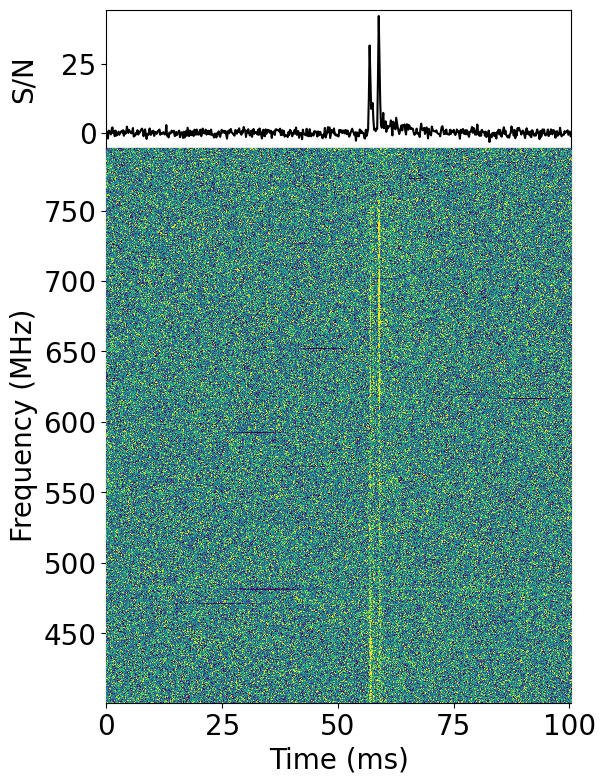

Profile already came in downsampled to:  64
SNR for initial downsampling factor 64: 42.32170892602956
The burst is already bright enough given the snr_cutoff at this downsample
We will use 64 as downsampling factor from now on
---------DM DETERMINATION---------
Not fitting for DM. Will use input DM of :  678.693261653568 . If you wanted to fit DM, set fit_DM = True.
Running get_snr() again now at the final DM of:  678.693261653568


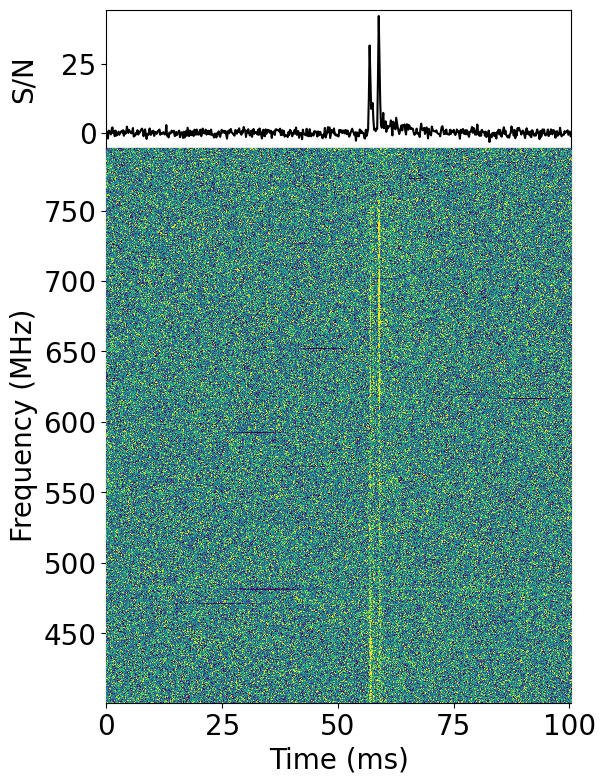

Getting the signal
Plotting a waterfall of the power


<Figure size 1000x1000 with 0 Axes>

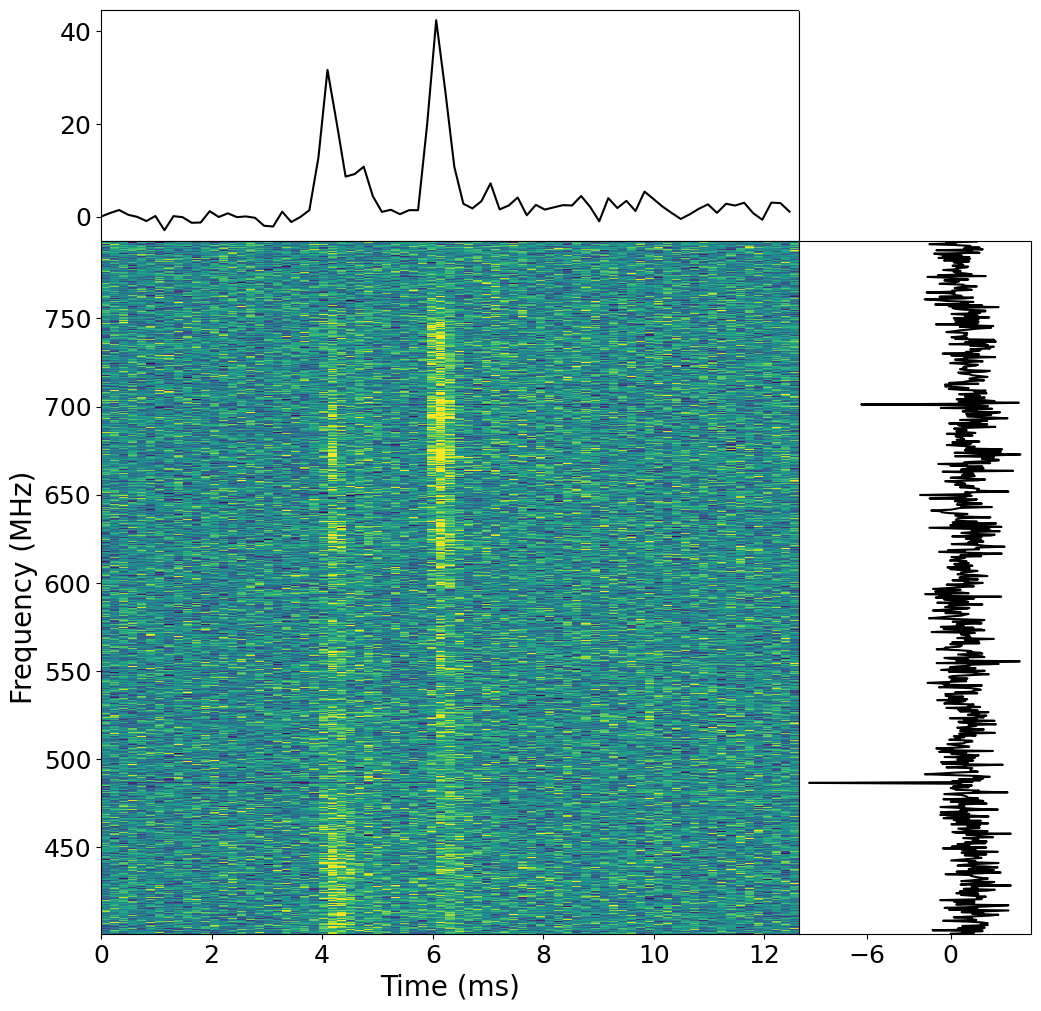

20608 25536


In [4]:
event = 22310619
dsamp = 64
dm =  678.693261653568

file = '/arc/projects/chime_frb/baseband_catalog/beamformed_files/FRB20181213A_22310619_beamformed.h5'


######## Getting the start and end time of the burst, Put Fit DM = True if you need structure maximizing DM ############

data, freq_id, freq, power, valid_channels, DM, DM_err, downsampling_factor, profile, t_res, start, full_power = singlebeam_to_input(file,
                                                                                                                                         DM = dm,
                                                                                                                                         downsample = dsamp,
                                                                                                                                         # time_range = [12445, 13258],
                                                                                                                                         fit_DM = False,
                                                                                                                                         #dm_range = 3,
                                                                                                                                         #spectrum_lim = False,
                                                                                                                                         fill_missing_time = False,
                                                                                                                                         diagnostic_plots = True,
                                                                                                                                         #raise_missing_signal = True,
                                                                                                                                         snr_cutoff = 20,
                                                                                                                                         # full_time = True, 
                                                                                                                                         #co_dedisp = True,
                                                                                                                                        )

gc.collect()
start_time, end_time = start, start+power.shape[-1]*t_res

##### This give you start and end time in the baseband dump at the best DM referenced at 400 MHz by default, you can change the reference frequency######

start_bin, end_bin = int(start_time/2.56e-6), int(end_time/2.56e-6) ##### To get the time bins at 2.56 us ######
print(start_bin, end_bin)

### Peaks at given time resolution (default 2.56 us) ###

The functionalities of make_input function is described here -

https://github.com/CHIMEFRB/baseband-analysis/blob/051adf011d82d73cd761cabfe88a60bff0e0f847/baseband_analysis/dev/Morphology_dev.py#L805


The output file it gives out since "get_fitburst_input = False" is described here

https://github.com/CHIMEFRB/baseband-analysis/blob/051adf011d82d73cd761cabfe88a60bff0e0f847/baseband_analysis/dev/Morphology_dev.py#L1071


You can use the index of peaks in output file. So to get the values in time for all individual peaks you can do the following 

peak_arrival_times in the baseband dump = start_time + peaks * t_res

Here start_time is from previous cell and t_res is the time resolution. In this case it will be 2.56 microsecond, but you can change the time resolution

Event id is 22310619
-----------------------------------
Stage 1: Getting the best downsampling factor, structure maximizing DM
-----------------------------------
Checking if baseband data was already de-smeared..
No DM in tiedbeam_baseband, so continuing on
---------Downsampling---------
Finding the best downsample. The SNr cutoff used is:  1
Profile already came in downsampled to:  1
SNR for initial downsampling factor 1: 8.44188530945124
The burst is already bright enough given the snr_cutoff at this downsample
We will use 1 as downsampling factor from now on
---------DM DETERMINATION---------
Not fitting for DM. Will use input DM of :  678.693261653568 . If you wanted to fit DM, set fit_DM = True.
Coherently dedispersing the data at the given DM of 678.693261653568 pc/cc
678.693261653568 678.693261653568 0
0.0 678.693261653568 678.693261653568


/arc/home/ksand/baseband-analysis/baseband_analysis/core/signal.py:930: RuntimeWarning: Mean of empty slice
  power = np.nanmean(power, -1)


Running get_snr() again now at the final DM of:  678.693261653568


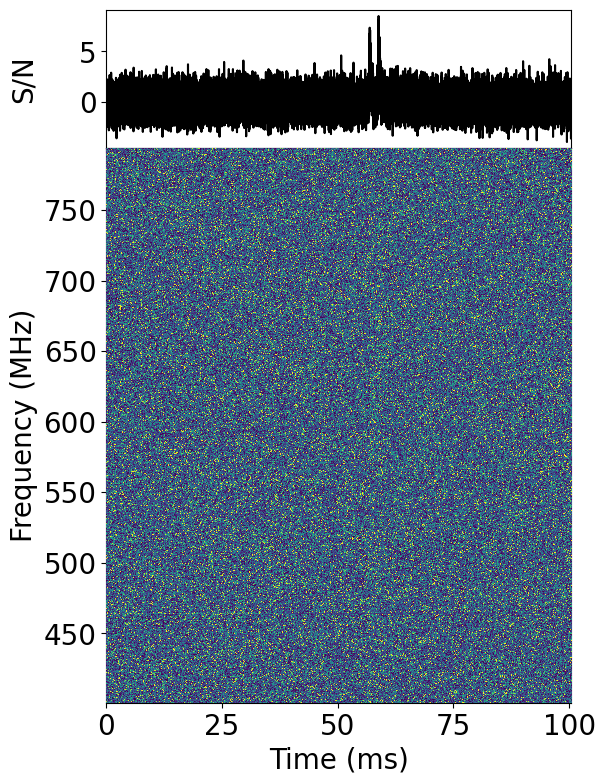

-----------------------------------
Stage 2: Finding peaks
-----------------------------------
1.8990893355317815
Best_frac being used is and the flag is 0.02848634003297672 True
Iteration 1: Smoothing the data and finding the peaks...
Number of peaks found 2
Iteration 2: Smoothing the data and finding the peaks...
Number of peaks found 2
Lowess smoothing fraction used: 0.02848634003297672
Prominence cutoff used:  0.8
Peaks:  [2400 1647]
Peaks*time resolution:  [0.006144   0.00421632]
Prominences of peaks:  [5.  3.9]
Heights of the peaks:  [4.79597844 3.79334714]


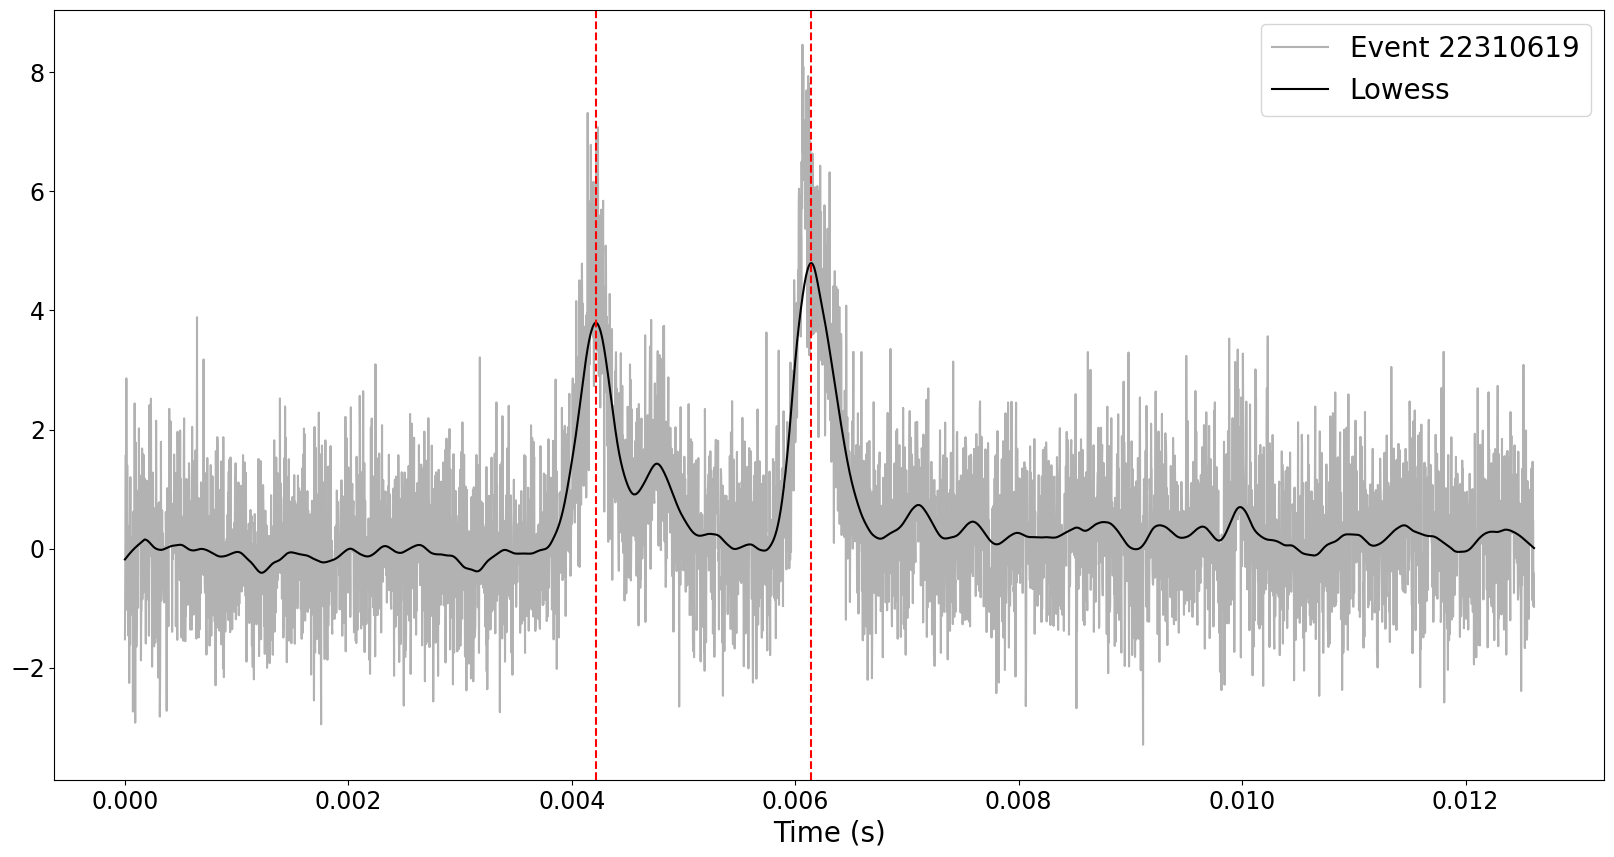

[1 0]
-----------------------------------
Stage 3: Generating an initial guess using LS
-----------------------------------
using heights from peak finding algorithm
Plotting the profile in blue, the initial fit guess in orange, and the peak in red


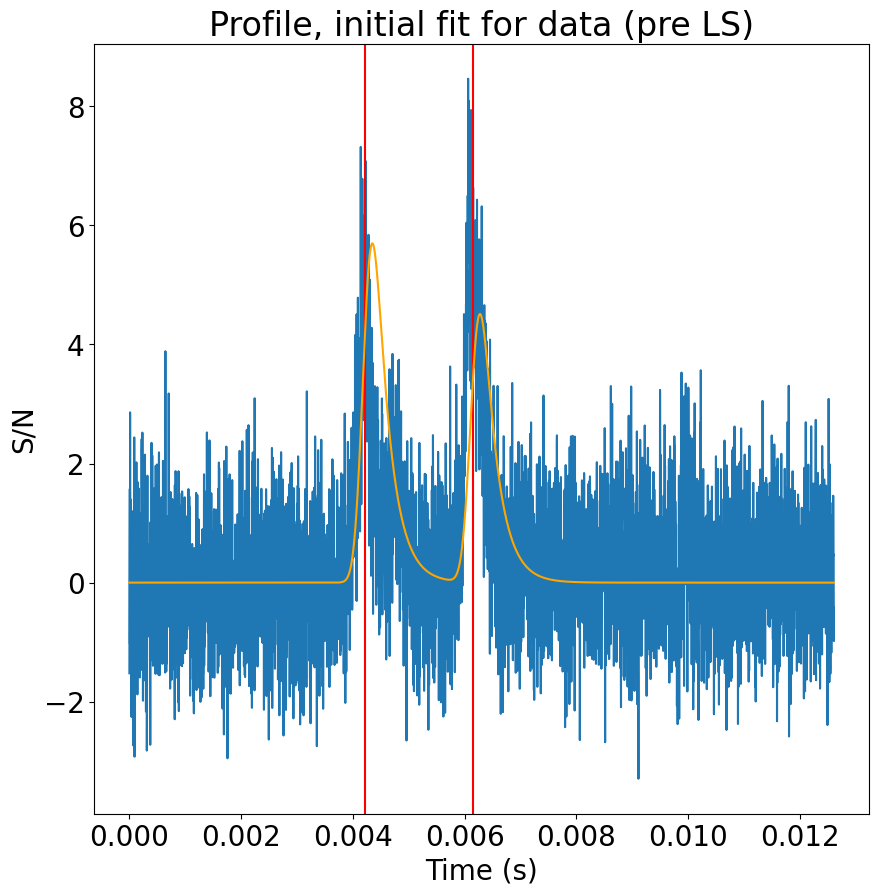

Now doing a curve_fit for the initial fit function to the data
Now plotting the results of the curve fit


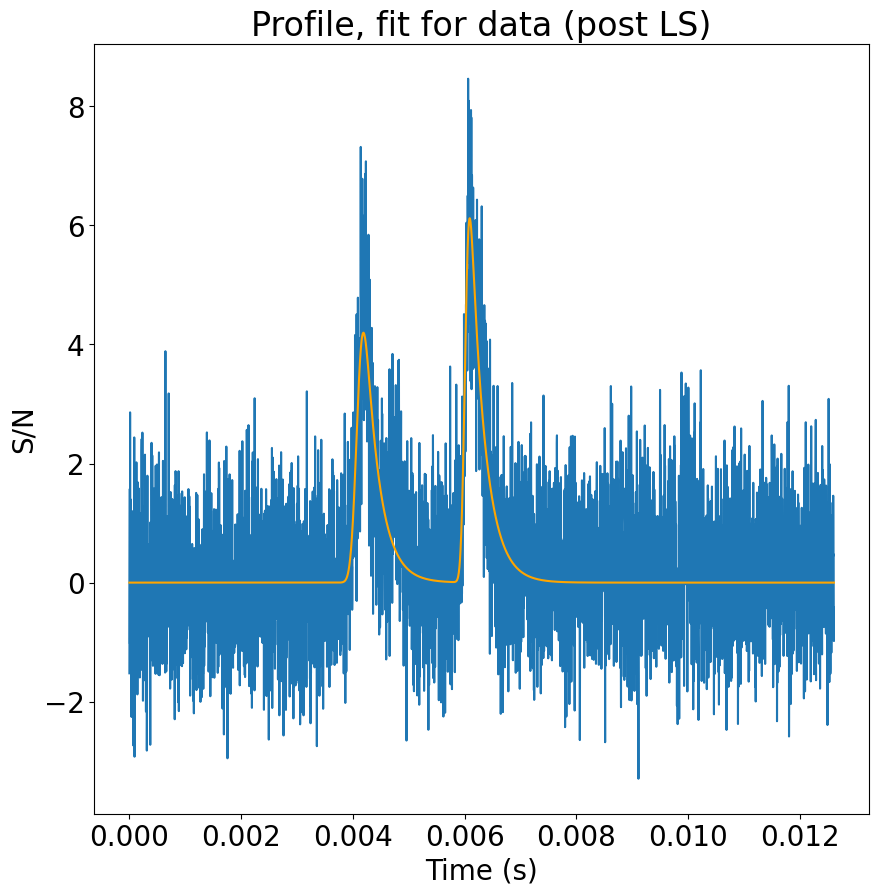

Curve_fit params: [1.87977398e-03 4.08576000e-03 8.68380718e-05 2.33692136e-03
 6.01361946e-03 5.59378411e-05 2.53051054e-04]
MEAN [0.00408576 0.00601362]
Reduced Chi Squared for Event X is 2.144
Fit of model to profile & residuals


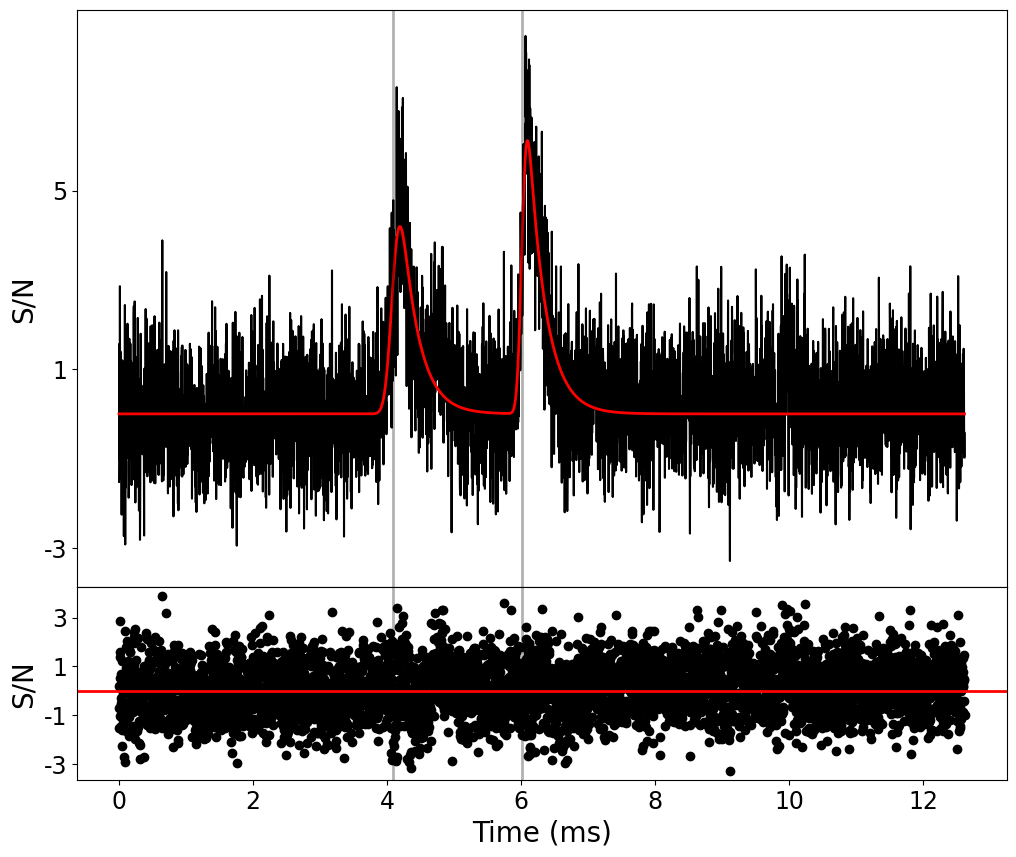

Below is a Q-Q plot of the residuals vs. that expected from a standard normal distribution.


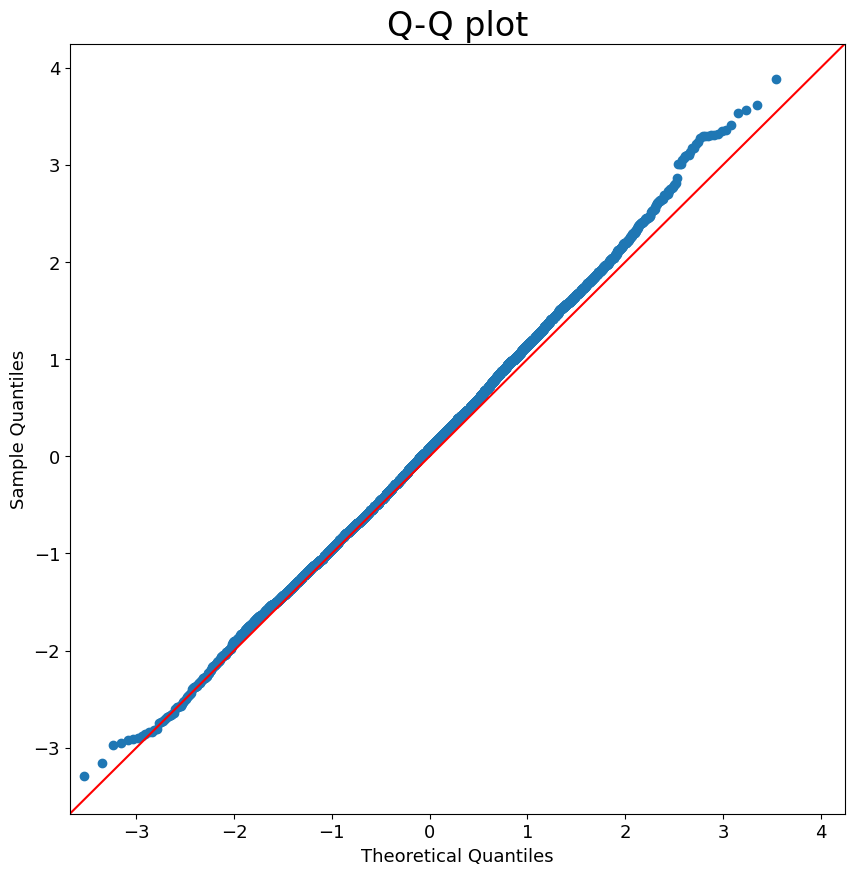

-----------------------------------
Stage 4: Generating only an npy file
-----------------------------------


(2, 1)

In [5]:

oname = '{}_high_res_data'.format(event)

####### Extracting the burst at highest time resolution #########

##### You can change this to whatever downsample you want #####



make_input(path = file,
           DM = dm,
           #downsample = dsamp, ### Set as 1 by default
           event_id = str(event),
           time_range = [start_bin, end_bin],
           fit_DM = False,
           snr_cutoff = 1,
           co_dedisp = True,
           get_fitburst_input = False,
           output_file_name = oname)
              

(807, 4928)
(1024, 4928)
=>> The dm error for event 22310619 is 0
678.693261653568
Waterfal shape (1024, 4928)
./22310619_wfall.jpg
Waterfall shape after scrunch (128, 4928)


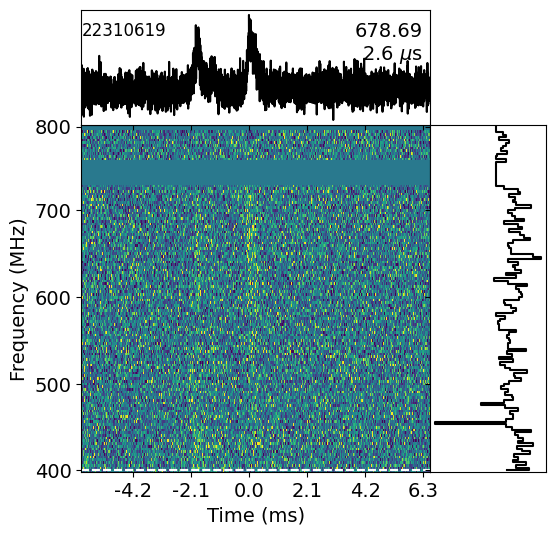

In [6]:
###### Plotting ######

input_file = oname + '.npz'
data_input = np.load(input_file, allow_pickle = True)
input_npz = data_input['power']
freq_id = data_input['freq_id']

print(input_npz.shape)

data_full = add_all_channels(input_npz, freq_id)

print(data_full.shape)

ds = int(data_input['t_res']/2.5e-6)
dm = data_input['DM']
dm_err = data_input['DM_error']

print("=>> The dm error for event {} is {}".format(event, dm_err))

print(dm)

wfall = data_full
print("Waterfal shape", wfall.shape)

#model_wfall = fit_result_npz
save_path = './'

f_scrunch = 8
t_scrunch = 1

f_res = (400/1024)*f_scrunch 
t_res = 2.56*ds*t_scrunch ### Time in micro ##

save_fname = save_path +str(event)+'_wfall.jpg'
print(save_fname)

if ds*t_scrunch < 1024:
    wfall = scrunch_npy(wfall, f_scrunch, t_scrunch)
else:
    print("Not Scrunching")

plot_event(wfall, f_res, t_res, dm, event, save_fname)